# 0. Instructions and setup

## 0.1. Instructions. Part 1: Setting Up the Problem (1.5 points)

- **Objective**: Understand and establish the baseline for your chosen dataset.

- **Tasks:**
  - **a. Bibliography and SOA (0.25 points):** Present briefly your task by researching and documenting the main  objective, a potential business case and the current state of the art  for your dataset's task. Include relevant benchmarks and methodologies.  You can look at google scholar, NLP index or papers with code. 
  - **b. Dataset Description (0.5 points):** Provide a brief overview of your dataset, including size, class  distribution, and any peculiar characteristics. Include basic  descriptive statistics.
  - **c. Random Classifier Performance (0.25 points):** Calculate the expected performance of a random classifier for your  dataset to set a benchmark. The calculation should include an  implementation. 
  - **d. Baseline Implementation (0.5 points):** Develop a rule-based classifier as a baseline. Discuss its performance in the  context of the dataset's complexity and compare it with human-level  performance if available.

## 0.2. Libraries

In [23]:
from datasets import load_dataset
from pprint import pprint
import polars as pl
import seaborn as sns
import random
from library.metrics import Metrics

In [5]:
# Initialize the metrics object to save the results
metrics = Metrics()

## 0.3. Random Seed

In [6]:
# Set random seed for reproducibility
random.seed(42)

# 1. Bibliography and SOA

# 2. Dataset Description: Swiss Judgement Prediction

Source: https://huggingface.co/datasets/rcds/swiss_judgment_prediction

## 2.1. Loading and reestructuring the data

In [7]:
# Load original dataset (with the original languages)
swiss_french = load_dataset('swiss_judgment_prediction', 'fr', trust_remote_code=True)
swiss_italian = load_dataset('swiss_judgment_prediction', 'it', trust_remote_code=True)

In [8]:
# Print the dataset structure for the French version
print("French version of the dataset:\n", swiss_french)
print("\nItalian version of the dataset:\n", swiss_italian)

French version of the dataset:
 DatasetDict({
    train: Dataset({
        features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
        num_rows: 21179
    })
    validation: Dataset({
        features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
        num_rows: 3095
    })
    test: Dataset({
        features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
        num_rows: 6820
    })
})

Italian version of the dataset:
 DatasetDict({
    train: Dataset({
        features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
        num_rows: 3072
    })
    validation: Dataset({
        features: ['id', 'year', 'text', 'label', 'language', 'region', 'canton', 'legal area', 'source_language'],
        num_rows: 408
    })
    test: Dataset({
        features: ['id', 'year', 'text'

In [9]:
# Access the first example in the training set
pprint(swiss_french['train'][0])

# Access the first example in the validation set
pprint(swiss_french['validation'][0])

# Access the first example in the test set
pprint(swiss_french['test'][0])

{'canton': 'n/a',
 'id': 0,
 'label': 0,
 'language': 'fr',
 'legal area': 'civil law',
 'region': 'n/a',
 'source_language': 'n/a',
 'text': "A.- Par contrat d'entreprise signé le 2 octobre 1998, Narcisse "
         'Pannatier, domicilié à Sion, a adjugé à Georges-André Dorsaz les '
         "travaux de construction d'une charpente pour une villa sise à Fully, "
         'dans le district de Martigny. Le 11 novembre 1998, Georges-André '
         'Dorsaz a adressé à Narcisse Pannatier une facture de 16 179 fr.85. '
         "Le maître de l'ouvrage a payé 15 712 fr.55. Diverses tentatives de "
         "recouvrement du solde à l'amiable ont échoué. B.- Par demande des 23 "
         'novembre/3 décembre 1999, Georges-André Dorsaz a ouvert action '
         'contre Narcisse Pannatier devant le juge de commune de Fully en vue '
         "d'obtenir le paiement de 467 fr. plus intérêts. Le juge de commune a "
         'fixé une audience au 4 février 2000. Le demandeur a donné suite à '
    

In [10]:
# Convert datasets to Polars DataFrames
def dataset_to_polars(dataset_split):
    """Convert a Hugging Face dataset split to a Polars DataFrame"""
    polars_df = dataset_split.to_polars()
    return polars_df

# Convert French dataset splits
french_train_df = dataset_to_polars(swiss_french['train'])
french_val_df = dataset_to_polars(swiss_french['validation'])
french_test_df = dataset_to_polars(swiss_french['test'])

# Convert Italian dataset splits
italian_train_df = dataset_to_polars(swiss_italian['train'])
italian_val_df = dataset_to_polars(swiss_italian['validation'])
italian_test_df = dataset_to_polars(swiss_italian['test'])

# Combine all French splits into one DataFrame with a split indicator
french_df = pl.concat([
    french_train_df.with_columns(pl.lit("train").alias("split")),
    french_val_df.with_columns(pl.lit("validation").alias("split")),
    french_test_df.with_columns(pl.lit("test").alias("split"))
])

# Combine all Italian splits into one DataFrame with a split indicator
italian_df = pl.concat([
    italian_train_df.with_columns(pl.lit("train").alias("split")),
    italian_val_df.with_columns(pl.lit("validation").alias("split")),
    italian_test_df.with_columns(pl.lit("test").alias("split"))
])

# Combine both languages into a single DataFrame
combined_df = pl.concat([french_df, italian_df])

print("Combined DataFrame shape:", combined_df.shape)
print("\nDataFrame schema:")
print(combined_df.schema)
print("\nFirst few rows:")
combined_df.head()

Combined DataFrame shape: (35386, 10)

DataFrame schema:
Schema({'id': Int32, 'year': Int32, 'text': String, 'label': Int64, 'language': String, 'region': String, 'canton': String, 'legal area': String, 'source_language': String, 'split': String})

First few rows:


id,year,text,label,language,region,canton,legal area,source_language,split
i32,i32,str,i64,str,str,str,str,str,str
0,2000,"""A.- Par contrat d'entreprise s…",0,"""fr""","""n/a""","""n/a""","""civil law""","""n/a""","""train"""
1,2000,"""A.- Le 12 avril 1995, A._ a su…",0,"""fr""","""n/a""","""n/a""","""insurance law""","""n/a""","""train"""
2,2000,"""A.- En février 1994, M._ a été…",0,"""fr""","""Région lémanique""","""ge""","""insurance law""","""n/a""","""train"""
3,2000,"""A.- M._ a travaillé en qualité…",0,"""fr""","""n/a""","""n/a""","""insurance law""","""n/a""","""train"""
6,2000,"""A.- Le 29 septembre 1997, X._ …",0,"""fr""","""Espace Mittelland""","""ne""","""penal law""","""n/a""","""train"""


In [11]:
# Remove columns that are not needed for the final dataset
columns_to_remove = ['source_language']
combined_df = combined_df.drop(columns_to_remove)

# Clean up "n/a" strings in several columns to actual NaN values
columns_to_clean = ['region', 'canton', 'legal area']

for column in columns_to_clean:
    combined_df = combined_df.with_columns(
        pl.col(column).replace("n/a", None)
    )

print("\nFirst few rows:")
combined_df.head()


First few rows:


id,year,text,label,language,region,canton,legal area,split
i32,i32,str,i64,str,str,str,str,str
0,2000,"""A.- Par contrat d'entreprise s…",0,"""fr""",null,null,"""civil law""","""train"""
1,2000,"""A.- Le 12 avril 1995, A._ a su…",0,"""fr""",null,null,"""insurance law""","""train"""
2,2000,"""A.- En février 1994, M._ a été…",0,"""fr""","""Région lémanique""","""ge""","""insurance law""","""train"""
3,2000,"""A.- M._ a travaillé en qualité…",0,"""fr""",null,null,"""insurance law""","""train"""
6,2000,"""A.- Le 29 septembre 1997, X._ …",0,"""fr""","""Espace Mittelland""","""ne""","""penal law""","""train"""


In [12]:
# Save the combined DataFrame to a Parquet file
combined_df.write_parquet('swiss_judgment_prediction_fr&it_clean.parquet')

## 2.2. EDA

**Data fields**:
- id: (int) a unique identifier of the for the document
- year: (int) the publication year
- text: (str) the facts of the case
- label: (class label) the judgment outcome: 0 (dismissal) or 1 (approval)
- language: (str) one of (de, fr, it)
- region: (str) the region of the lower court
- canton: (str) the canton of the lower court
- legal area: (str) the legal area of the case 

In [13]:
# Load the cleaned Parquet file
df = pl.read_parquet('swiss_judgment_prediction_fr&it_clean.parquet')

# Display the loaded DataFrame
print("\nLoaded DataFrame shape:", df.shape)
print("\nLoaded DataFrame schema:")
print(df.schema)
print("\nFirst few rows of the loaded DataFrame:")
df.head()


Loaded DataFrame shape: (35386, 9)

Loaded DataFrame schema:
Schema({'id': Int32, 'year': Int32, 'text': String, 'label': Int64, 'language': String, 'region': String, 'canton': String, 'legal area': String, 'split': String})

First few rows of the loaded DataFrame:


id,year,text,label,language,region,canton,legal area,split
i32,i32,str,i64,str,str,str,str,str
0,2000,"""A.- Par contrat d'entreprise s…",0,"""fr""",null,null,"""civil law""","""train"""
1,2000,"""A.- Le 12 avril 1995, A._ a su…",0,"""fr""",null,null,"""insurance law""","""train"""
2,2000,"""A.- En février 1994, M._ a été…",0,"""fr""","""Région lémanique""","""ge""","""insurance law""","""train"""
3,2000,"""A.- M._ a travaillé en qualité…",0,"""fr""",null,null,"""insurance law""","""train"""
6,2000,"""A.- Le 29 septembre 1997, X._ …",0,"""fr""","""Espace Mittelland""","""ne""","""penal law""","""train"""


shape: (3, 5)
┌────────────┬───────┬──────┬───────┬───────┐
│ split      ┆ 0     ┆ 1    ┆ 0_pct ┆ 1_pct │
│ ---        ┆ ---   ┆ ---  ┆ ---   ┆ ---   │
│ str        ┆ u32   ┆ u32  ┆ f64   ┆ f64   │
╞════════════╪═══════╪══════╪═══════╪═══════╡
│ test       ┆ 6216  ┆ 1416 ┆ 81.45 ┆ 18.55 │
│ train      ┆ 18429 ┆ 5822 ┆ 75.99 ┆ 24.01 │
│ validation ┆ 2789  ┆ 714  ┆ 79.62 ┆ 20.38 │
└────────────┴───────┴──────┴───────┴───────┘


C:\Users\matia\AppData\Local\Temp\ipykernel_32240\2115700903.py:7: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  label_pivot = label_distribution.pivot(


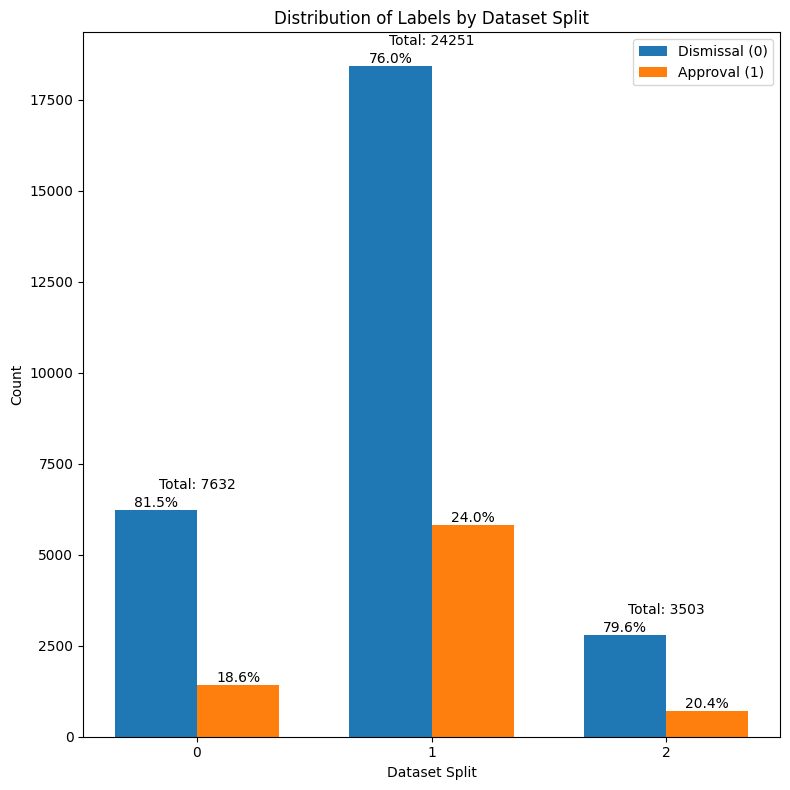

In [19]:
import numpy as np
import matplotlib.pyplot as plt

label_distribution = df.group_by(['split', 'label']).len().sort(['split', 'label'])

# Pivot
label_pivot = label_distribution.pivot(
    index='split',
    columns='label',
    values='len'
).sort(['split'])

total_by_split = label_pivot.select(pl.col('0') + pl.col('1')).rename({'0': 'total'})
label_pivot_with_pct = label_pivot.with_columns([
    (pl.col('0') / (pl.col('0') + pl.col('1')) * 100).round(2).alias('0_pct'),
    (pl.col('1') / (pl.col('0') + pl.col('1')) * 100).round(2).alias('1_pct')
])

print(label_pivot_with_pct)

splits = label_pivot.to_pandas().index.tolist()
label_0_counts = label_pivot.select('0').to_numpy().flatten()
label_1_counts = label_pivot.select('1').to_numpy().flatten()

fig, ax = plt.subplots(figsize=(8, 8))
width = 0.35
x = np.arange(len(splits))

bar1 = ax.bar(x - width/2, label_0_counts, width, label='Dismissal (0)')
bar2 = ax.bar(x + width/2, label_1_counts, width, label='Approval (1)')

for i, bar in enumerate(bar1):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{label_pivot_with_pct["0_pct"][i]:.1f}%', 
            ha='center', va='bottom')

for i, bar in enumerate(bar2):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{label_pivot_with_pct["1_pct"][i]:.1f}%', 
            ha='center', va='bottom')

# Add labels, title, and legend
ax.set_xlabel('Dataset Split')
ax.set_ylabel('Count')
ax.set_title('Distribution of Labels by Dataset Split')
ax.set_xticks(x)
ax.set_xticklabels(splits)
ax.legend()

# Add total counts above the pairs of bars
for i in range(len(splits)):
    total = label_0_counts[i] + label_1_counts[i]
    ax.text(i, max(label_0_counts[i], label_1_counts[i]) + 500, 
            f'Total: {total}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 3. Random Classifier Performance

Metrics calculated for: random_classifier_train

===== Random Classifier - TRAIN =====

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     18429
           1       0.24      0.24      0.24      5822

    accuracy                           0.64     24251
   macro avg       0.50      0.50      0.50     24251
weighted avg       0.64      0.64      0.64     24251

Metrics calculated for: random_classifier_validation

===== Random Classifier - VALIDATION =====

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      2789
           1       0.21      0.25      0.23       714

    accuracy                           0.66      3503
   macro avg       0.51      0.51      0.51      3503
weighted avg       0.68      0.66      0.67      3503

Metrics calculated for: random_classifier_test

===== Random Classifier - TEST =====

Classification Report:
     

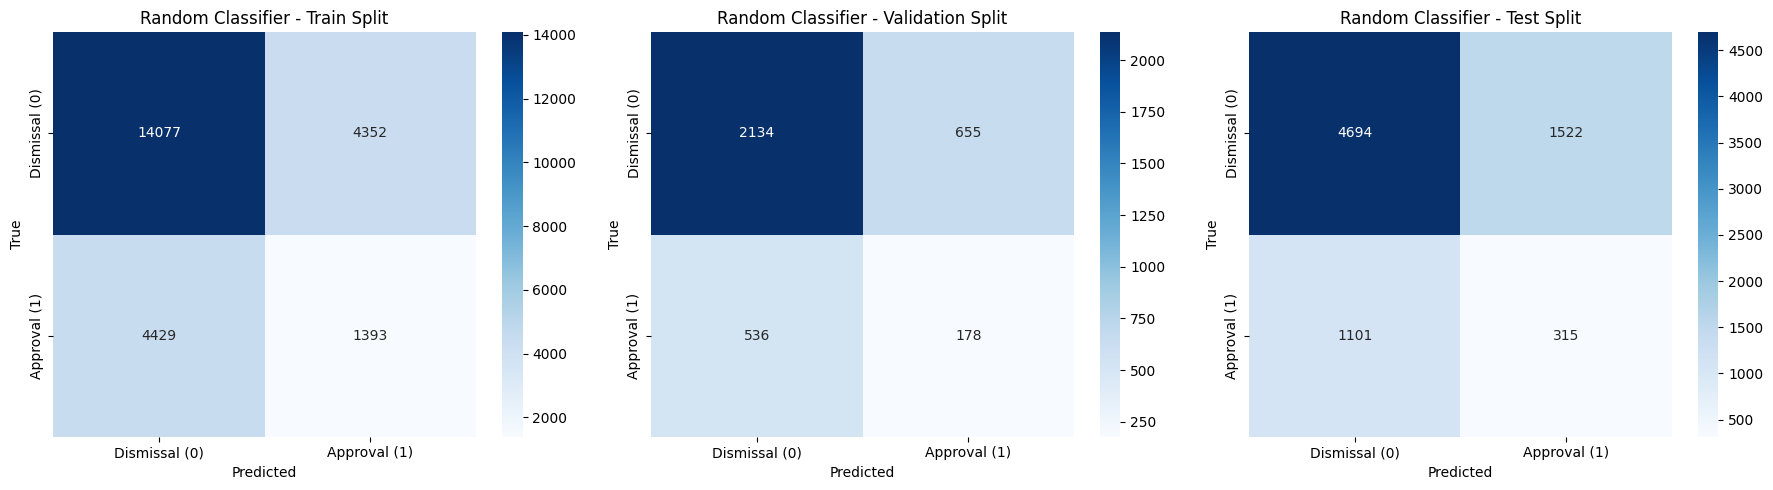


Metrics for random_classifier_train

Accuracy: 63.79%

Precision: 24.25%

Recall: 23.93%

F1 Score: 24.09%

Metrics for random_classifier_validation

Accuracy: 66.00%

Precision: 21.37%

Recall: 24.93%

F1 Score: 23.01%

Metrics for random_classifier_test

Accuracy: 65.63%

Precision: 17.15%

Recall: 22.25%

F1 Score: 19.37%


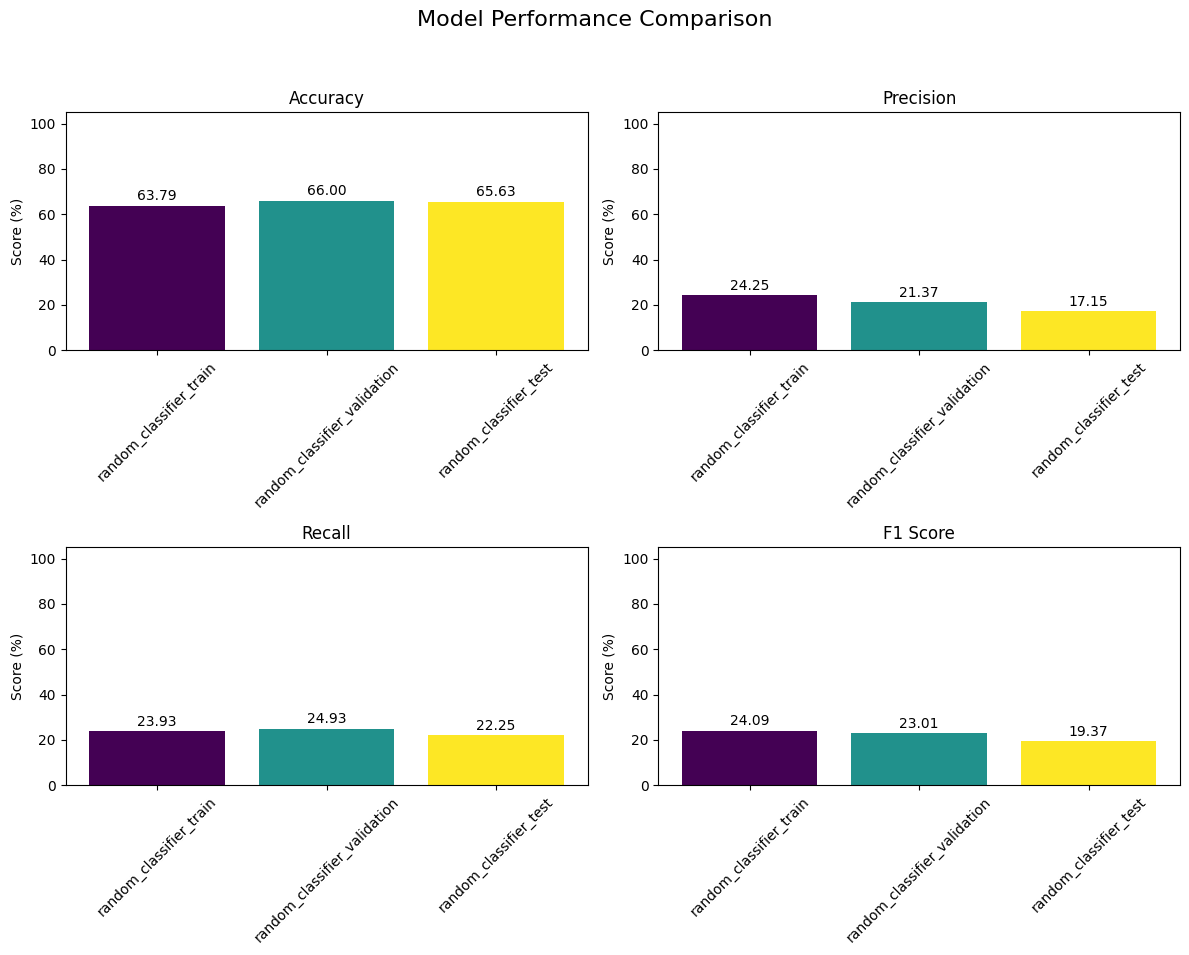

Expected accuracy of a naive random (50/50) classifier: 50.00%
Expected accuracy of a random classifier based on majority class: 81.45%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def random_classifier(data, split_name):
    split_data = data.filter(pl.col('split') == split_name)
    
    # Get label distribution from train
    label_dist_train = df.filter(pl.col('split') == 'train').group_by('label').len()
    total_train = label_dist_train['len'].sum()
    class_probs = {row['label']: row['len'] / total_train for row in label_dist_train.to_dicts()}
    
    y_true = split_data.select('label').to_numpy().flatten()
    y_pred = np.random.choice([0, 1], size=len(y_true), p=[class_probs[0], class_probs[1]])
    
    return y_true, y_pred

# Run random classifyer
results = {}
for split in ['train', 'validation', 'test']:
    y_true, y_pred = random_classifier(df, split)
    
    # Use the Metrics class from our library
    metrics.run(y_true, y_pred, f'random_classifier_{split}', average='binary')
    
    # Store confusion matrix for visualization (not handled by Metrics class)
    results[split] = {
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }
    
    # Print additional information
    print(f"\n===== Random Classifier - {split.upper()} =====")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
splits = ['train', 'validation', 'test']

for i, split in enumerate(splits):
    conf_mat = results[split]['confusion_matrix']
    
    # Plot confusion matrix
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Dismissal (0)', 'Approval (1)'],
                yticklabels=['Dismissal (0)', 'Approval (1)'],
                ax=axes[i])
    
    axes[i].set_title(f'Random Classifier - {split.capitalize()} Split')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()

# Print all metrics results
metrics.print_results()

# Plot the metrics comparison
metrics.plot()

# The expected performance of a random classifier without using the known distribution
# would be approximately equal to the majority class percentage:
majority_class_percentage = label_pivot_with_pct.select(pl.col('0_pct').max()).item()
print(f"Expected accuracy of a naive random (50/50) classifier: 50.00%")
print(f"Expected accuracy of a random classifier based on majority class: {majority_class_percentage:.2f}%")

# 4. Baseline Implementation